# Goal: Build a multi-task model that predicts


A multi-output model has one shared model body (e.g., a transformer) and multiple independent output heads — one for each task (or label column). Each output is predicted independently, even if trained jointly.

Example:

  One model outputs:
  *   Binary: hatespeech
  *   Multi-class: directness_label
  *   Multi-class: target_label
  *   Multi-class: group_label
  *   Multi-label: 8 sentiments

Each of these heads has no explicit dependency on the others.



In [2]:
!pip install -q evaluate torchinfo bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.6 MB/s eta 0:00:00


In [37]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel
import pandas as pd

import numpy as np
from datasets import Dataset
import evaluate
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from torchinfo import summary
import torch
from transformers import BertTokenizer, BertForSequenceClassification, BitsAndBytesConfig
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Datasets, Tokenizer and Model

In [6]:
#load dataset
train_df = pd.read_csv('/content/drive/MyDrive/combined_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/combined_test.csv')
val_df = pd.read_csv('/content/drive/MyDrive/combined_val.csv')

In [7]:
train_df = train_df.dropna(subset=["text_cleaned"])
test_df = test_df.dropna(subset=["text_cleaned"])
val_df = val_df.dropna(subset=["text_cleaned"])

In [8]:

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [9]:
def fix_text_column(df):
    df = df.copy()
    df['text_cleaned'] = df['text_cleaned'].fillna('').astype(str)
    return df

train_df = fix_text_column(train_df)
val_df = fix_text_column(val_df)
test_df = fix_text_column(test_df)


In [10]:
print(train_df['text_cleaned'].apply(type).value_counts())

text_cleaned
<class 'str'>    30695
Name: count, dtype: int64


In [11]:
#convert to HuggingFace dataset / format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
val_dataset = Dataset.from_pandas(val_df)

In [12]:
# Sentiment columns to treat as multi-label binary classification
sentiment_cols = [
    'sentiment_anger', 'sentiment_confusion', 'sentiment_disgust',
    'sentiment_fear', 'sentiment_indifference', 'sentiment_normal',
    'sentiment_sadness', 'sentiment_shock']

In [13]:
# Tokenizer
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

# Dataset Class
Preprocess data to handle any missing values and ensure all entries are strings

- return everything the model needs in one unified format

- this supports tokenization and label extraction

- Added language to allow per language analysis

In [14]:
from torch.utils.data import Dataset
import torch

class MultiTaskDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128, sentiment_cols=None):
        """
        df: pandas DataFrame with all required columns
        tokenizer: Huggingface tokenizer (e.g., RobertaTokenizer)
        max_len: max token length for truncation/padding
        sentiment_cols: list of sentiment column names in df
        """
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.sentiment_cols = sentiment_cols if sentiment_cols is not None else []

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get row as a pandas Series
        row = self.df.iloc[idx]

        # tokenize the text
        encoding = self.tokenizer(
            str(row['text_cleaned']),
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Extract sentiment values as float tensor if sentiment columns given
        sentiments = None
        if self.sentiment_cols:
            sentiments = torch.tensor(row[self.sentiment_cols].values.astype(float), dtype=torch.float)
        else:
            sentiments = torch.empty(0)  # empty tensor if none

        # Construct output dictionary with tensors and scalars converted properly
        return {
            'input_ids': encoding['input_ids'].squeeze(0),       # shape: (max_len,)
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'hate': torch.tensor(float(row['hatespeech']), dtype=torch.float),  # binary float
            'directness': torch.tensor(int(row['directness_label']), dtype=torch.long),
            'target': torch.tensor(int(row['target_label']), dtype=torch.long),
            'group': torch.tensor(int(row['group_label']), dtype=torch.long),
            'sentiments': sentiments  # float tensor of sentiments (length 8 if given)
        }

In [15]:
from torch.utils.data import Dataset
import torch

class MultiTaskDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128, sentiment_cols=None):
        """
        df: pandas DataFrame with all required columns
        tokenizer: Huggingface tokenizer (e.g., RobertaTokenizer)
        max_len: max token length for truncation/padding
        sentiment_cols: list of sentiment column names in df
        """
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.sentiment_cols = sentiment_cols if sentiment_cols is not None else []

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get row as a pandas Series
        row = self.df.iloc[idx]

        # tokenize the text
        encoding = self.tokenizer(
            str(row['text_cleaned']),
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Extract sentiment values as float tensor if sentiment columns given
        sentiments = None
        if self.sentiment_cols:
            sentiments = torch.tensor(row[self.sentiment_cols].values.astype(float), dtype=torch.float)
        else:
            sentiments = torch.empty(0)  # empty tensor if none

        # Construct output dictionary with tensors and scalars converted properly
        return {
          'input_ids': encoding['input_ids'].squeeze(0),
          'attention_mask': encoding['attention_mask'].squeeze(0),
          'hate': torch.tensor(float(row['hatespeech']), dtype=torch.float),
          'directness': torch.tensor(int(row['directness_label']), dtype=torch.long),
          'target': torch.tensor(int(row['target_label']), dtype=torch.long),
          'group': torch.tensor(int(row['group_label']), dtype=torch.long),
          'sentiments': sentiments,
          'language': row['language_encoded']
      }


# Define Model
- Roberta learns general representations
- separate heads specialize for each task
- this improves performance when tasks are related

In [16]:
import torch.nn as nn
from transformers import RobertaModel

class MultiTaskRoberta(nn.Module):
    def __init__(self):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        hidden_size = self.roberta.config.hidden_size

        self.hate_head = nn.Linear(hidden_size, 1)
        self.directness_head = nn.Linear(hidden_size, 3)
        self.target_head = nn.Linear(hidden_size, 7)
        self.group_head = nn.Linear(hidden_size, 17)
        self.sentiment_head = nn.Linear(hidden_size, 8)

    def forward(self, input_ids, attention_mask):
      outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
      hidden_state = outputs.last_hidden_state  # or however you use it
      pooled_output = hidden_state[:, 0, :]  # CLS token

      hate_logits = self.hate_head(pooled_output)
      hate_logits = hate_logits.squeeze(-1)  # now shape is [batch_size]
      directness_logits = self.directness_head(pooled_output)
      target_logits = self.target_head(pooled_output)
      group_logits = self.group_head(pooled_output)
      sentiment_logits = self.sentiment_head(pooled_output)

      return {
          'hate': hate_logits,
          'directness': directness_logits,
          'target': target_logits,
          'group': group_logits,
          'sentiments': sentiment_logits,
      }

# Define Loss Function
- BCEWithLogitsLoss for hatespeech and sentiments
    -  binary / multi - label
- Cross Entropy Loss for directness, target, group
    - multi- class

Add all of them (possibly weighted) to form total loss

In [17]:
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss

def compute_multitask_loss(preds, labels):
    bce = BCEWithLogitsLoss()
    ce = CrossEntropyLoss()

    return (
        1.0 * bce(preds['hate'], labels['hate']) +
        0.7 * ce(preds['directness'], labels['directness']) +
        0.7 * ce(preds['target'], labels['target']) +
        0.7 * ce(preds['group'], labels['group']) +
        1.0 * bce(preds['sentiments'], labels['sentiments'])
    )

In [18]:
sentiment_cols = [
    'sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear',
    'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock'
]

Dataloader batches the data, shuffling training data and makes iteration efficiency during training and evaluation

In [19]:
train_dataset = MultiTaskDataset(train_df, tokenizer, max_len=128, sentiment_cols=sentiment_cols)
val_dataset = MultiTaskDataset(val_df, tokenizer, max_len=128, sentiment_cols=sentiment_cols)
test_dataset = MultiTaskDataset(test_df, tokenizer, max_len=128, sentiment_cols=sentiment_cols)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# Model Training
- loop through batches
- backpropagate total loss
- update model parameters

In [20]:
from torch.optim import AdamW
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskRoberta().to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

for epoch in range(3):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()

        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device)
        }

        labels = {
            'hate': batch['hate'].to(device),
            'directness': batch['directness'].to(device),
            'target': batch['target'].to(device),
            'group': batch['group'].to(device),
            'sentiments': batch['sentiments'].to(device)
        }

        preds = model(**inputs)
        loss = compute_multitask_loss(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1:   0%|          | 0/480 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 1:   0%|          | 1/480 [00:02<18:18,  2.29s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 1:   0%|          | 2/480 [00:03<12:52,  1.62s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: Futu

Epoch 1 Loss: 2.3900


Epoch 2:   0%|          | 0/480 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 2:   0%|          | 1/480 [00:01<10:03,  1.26s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 2:   0%|          | 2/480 [00:02<09:55,  1.25s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 2:   1%|          | 3/480 [00:03<09:52,  1.24s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/mod

Epoch 2 Loss: 1.7118


Epoch 3:   0%|          | 0/480 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 3:   0%|          | 1/480 [00:01<10:10,  1.28s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 3:   0%|          | 2/480 [00:02<10:05,  1.27s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 3:   1%|          | 3/480 [00:03<10:07,  1.27s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/mod

Epoch 3 Loss: 1.5673


# Evaluate the Model

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def evaluate(model, dataloader):
    model.eval()

    # Store predictions and labels for each task
    all_preds = {
        'hate': [], 'directness': [], 'target': [], 'group': [], 'sentiments': []
    }
    all_labels = {
        'hate': [], 'directness': [], 'target': [], 'group': [], 'sentiments': []
    }

    for batch in tqdm(dataloader, desc="Evaluating"):
        with torch.no_grad():
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device)
            }
            outputs = model(**inputs)

        # Hate (binary)
        hate_preds = (torch.sigmoid(outputs['hate']) > 0.5).long().cpu().numpy().flatten()
        hate_labels = batch['hate'].long().cpu().numpy().flatten()
        all_preds['hate'].extend(hate_preds)
        all_labels['hate'].extend(hate_labels)

        # Directness (multi-class)
        dir_preds = torch.argmax(outputs['directness'], dim=1).cpu().numpy()
        dir_labels = batch['directness'].cpu().numpy()
        all_preds['directness'].extend(dir_preds)
        all_labels['directness'].extend(dir_labels)

        # Target (multi-class)
        tgt_preds = torch.argmax(outputs['target'], dim=1).cpu().numpy()
        tgt_labels = batch['target'].cpu().numpy()
        all_preds['target'].extend(tgt_preds)
        all_labels['target'].extend(tgt_labels)

        # Group (multi-class)
        grp_preds = torch.argmax(outputs['group'], dim=1).cpu().numpy()
        grp_labels = batch['group'].cpu().numpy()
        all_preds['group'].extend(grp_preds)
        all_labels['group'].extend(grp_labels)

        # Sentiments (multi-label with 8 categories)
        sent_preds = (torch.sigmoid(outputs['sentiments']) > 0.5).int().cpu().numpy()
        sent_labels = batch['sentiments'].int().cpu().numpy()
        all_preds['sentiments'].extend(sent_preds)
        all_labels['sentiments'].extend(sent_labels)

    print("\n--- Evaluation Metrics ---\n")

    # HATE
    print("HATE (Binary):")
    print("  Accuracy:", accuracy_score(all_labels['hate'], all_preds['hate']))
    print("  Precision:", precision_score(all_labels['hate'], all_preds['hate'], zero_division=0))
    print("  Recall:", recall_score(all_labels['hate'], all_preds['hate'], zero_division=0))
    print("  F1 Score:", f1_score(all_labels['hate'], all_preds['hate'], zero_division=0))
    print()

    # DIRECTNESS
    print("DIRECTNESS (Multi-Class):")
    print("  Accuracy:", accuracy_score(all_labels['directness'], all_preds['directness']))
    print("  Precision (macro):", precision_score(all_labels['directness'], all_preds['directness'], average='macro', zero_division=0))
    print("  Recall (macro):", recall_score(all_labels['directness'], all_preds['directness'], average='macro', zero_division=0))
    print("  F1 Score (macro):", f1_score(all_labels['directness'], all_preds['directness'], average='macro', zero_division=0))
    print()

    # TARGET
    print("TARGET (Multi-Class):")
    print("  Accuracy:", accuracy_score(all_labels['target'], all_preds['target']))
    print("  Precision (macro):", precision_score(all_labels['target'], all_preds['target'], average='macro', zero_division=0))
    print("  Recall (macro):", recall_score(all_labels['target'], all_preds['target'], average='macro', zero_division=0))
    print("  F1 Score (macro):", f1_score(all_labels['target'], all_preds['target'], average='macro', zero_division=0))
    print()

    # GROUP
    print("GROUP (Multi-Class):")
    print("  Accuracy:", accuracy_score(all_labels['group'], all_preds['group']))
    print("  Precision (macro):", precision_score(all_labels['group'], all_preds['group'], average='macro', zero_division=0))
    print("  Recall (macro):", recall_score(all_labels['group'], all_preds['group'], average='macro', zero_division=0))
    print("  F1 Score (macro):", f1_score(all_labels['group'], all_preds['group'], average='macro', zero_division=0))
    print()

    # SENTIMENTS
    print("SENTIMENTS (Multi-Label, 8 classes):")
    sent_preds = np.vstack(all_preds['sentiments'])
    sent_labels = np.vstack(all_labels['sentiments'])

    print("sent_preds shape:", sent_preds.shape, "dtype:", sent_preds.dtype)
    print("sent_labels shape:", sent_labels.shape, "dtype:", sent_labels.dtype)
    print("sent_preds sample:", sent_preds[:3])
    print("sent_labels sample:", sent_labels[:3])




In [22]:
evaluate(model, val_loader)

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   2%|▏         | 1/61 [00:00<00:37,  1.60it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   3%|▎         | 2/61 [00:01<00:30,  1.96it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating:   5%|▍         | 3/61 [00:01<00:27,  2.13it/s]/usr/local/lib/python3.11/dist-packages/torc


--- Evaluation Metrics ---

HATE (Binary):
  Accuracy: 0.9466666666666667
  Precision: 0.9152964623816642
  Recall: 0.9797333333333333
  F1 Score: 0.9464193714580114

DIRECTNESS (Multi-Class):
  Accuracy: 0.84
  Precision (macro): 0.7639131166559471
  Recall (macro): 0.7776568743512965
  F1 Score (macro): 0.7695027610272551

TARGET (Multi-Class):
  Accuracy: 0.7964102564102564
  Precision (macro): 0.6587316493551246
  Recall (macro): 0.6823555769736499
  F1 Score (macro): 0.6580537693621028

GROUP (Multi-Class):
  Accuracy: 0.7251282051282051
  Precision (macro): 0.43575603140608876
  Recall (macro): 0.4779365665037139
  F1 Score (macro): 0.41886786179816493

SENTIMENTS (Multi-Label, 8 classes):
sent_preds shape: (3900, 8) dtype: int32
sent_labels shape: (3900, 8) dtype: int32
sent_preds sample: [[0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]]
sent_labels sample: [[0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0]]


language one

In [ ]:
evaluate(model, val_loader)

Evaluating: 100%|██████████| 61/61 [00:27<00:00,  2.24it/s]


--- Evaluation Metrics ---

HATE (Binary):
  Accuracy: 0.9456410256410256
  Precision: 0.9172102358253889
  Recall: 0.9749333333333333
  F1 Score: 0.9451913133402275

DIRECTNESS (Multi-Class):
  Accuracy: 0.8417948717948718
  Precision (macro): 0.7644179149131953
  Recall (macro): 0.7739530862388774
  F1 Score (macro): 0.7685757172924707

TARGET (Multi-Class):
  Accuracy: 0.8017948717948717
  Precision (macro): 0.6627566189741005
  Recall (macro): 0.698003703030135
  F1 Score (macro): 0.6736141725355689

GROUP (Multi-Class):
  Accuracy: 0.7333333333333333
  Precision (macro): 0.4060003570387702
  Recall (macro): 0.4461493780935425
  F1 Score (macro): 0.4079440647094941

SENTIMENTS (Multi-Label, 8 classes):
sent_preds shape: (3900, 8) dtype: int32
sent_labels shape: (3900, 8) dtype: int32
sent_preds sample: [[0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]]
sent_labels sample: [[0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0]]


In [ ]:
evaluate(model, val_loader)

Evaluating: 100%|██████████| 61/61 [00:25<00:00,  2.36it/s]


--- Evaluation Metrics ---

HATE (Binary):
  Accuracy: 0.9353846153846154
  Precision: 0.8925979680696662
  Recall: 0.984
  F1 Score: 0.9360730593607306

DIRECTNESS (Multi-Class):
  Accuracy: 0.8284615384615385
  Precision (macro): 0.743196322817544
  Recall (macro): 0.7371162425580905
  F1 Score (macro): 0.7359459292615235

TARGET (Multi-Class):
  Accuracy: 0.7879487179487179
  Precision (macro): 0.6512009786680923
  Recall (macro): 0.6826286484660476
  F1 Score (macro): 0.648696186908427

GROUP (Multi-Class):
  Accuracy: 0.7248717948717949
  Precision (macro): 0.4244796942662043
  Recall (macro): 0.4495169756437253
  F1 Score (macro): 0.41784705043099035

SENTIMENTS (Multi-Label, 8 classes):
sent_preds shape: (3900, 8) dtype: int32
sent_labels shape: (3900, 0) dtype: int32
sent_preds sample: [[0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0]]
sent_labels sample: []


# Save Model

In [ ]:
torch.save(model.state_dict(), "roberta_multitask_model.pth")

In [ ]:
model = MultiTaskModel()
model.load_state_dict(torch.load("roberta_multitask_model.pth"))
model.to(device)

NameError: name 'MultiTaskModel' is not defined

In [ ]:
import os
import torch
import shutil
from IPython.display import FileLink

save_dir = "multitask_model"
os.makedirs(save_dir, exist_ok=True)

# Save model weights
torch.save(model.state_dict(), os.path.join(save_dir, "pytorch_model.bin"))

# Save tokenizer (only works if using HuggingFace tokenizer)
tokenizer.save_pretrained(save_dir)

# Zip the folder
shutil.make_archive("multitask_model", 'zip', save_dir)

# Generate download link
FileLink("multitask_model.zip")


/content/multitask_model.zip

# Confusion Matrix
To inspect where the model struggles

Per-language reveals cultural performance gaps or tokenization issues

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_preds = {'hate': [], 'directness': [], 'target': [], 'group': [], 'sentiments': []}
all_labels = {'hate': [], 'directness': [], 'target': [], 'group': [], 'sentiments': []}

model.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k not in ['hate', 'directness', 'target', 'group', 'sentiments', 'language']}
        outputs = model(**inputs)

        # HATE
        hate_logits = outputs['hate']
        hate_preds = (torch.sigmoid(hate_logits).cpu().numpy() > 0.5).astype(int)
        all_preds['hate'].extend(hate_preds.flatten())
        all_labels['hate'].extend(batch['hate'].cpu().numpy().flatten())

        # DIRECTNESS, TARGET, GROUP — assumed multi-class
        for key in ['directness', 'target', 'group']:
            pred = torch.argmax(outputs[key], dim=1).cpu().numpy()
            all_preds[key].extend(pred)
            all_labels[key].extend(batch[key].cpu().numpy())

        # SENTIMENTS — multi-label (8 binary outputs)
        sentiments_logits = outputs['sentiments']
        sentiments_preds = (torch.sigmoid(sentiments_logits).cpu().numpy() > 0.5).astype(int)
        all_preds['sentiments'].extend(sentiments_preds)
        all_labels['sentiments'].extend(batch['sentiments'].cpu().numpy())



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.1

In [ ]:
train_df['directness_label'].unique()

array([2, 1, 0])

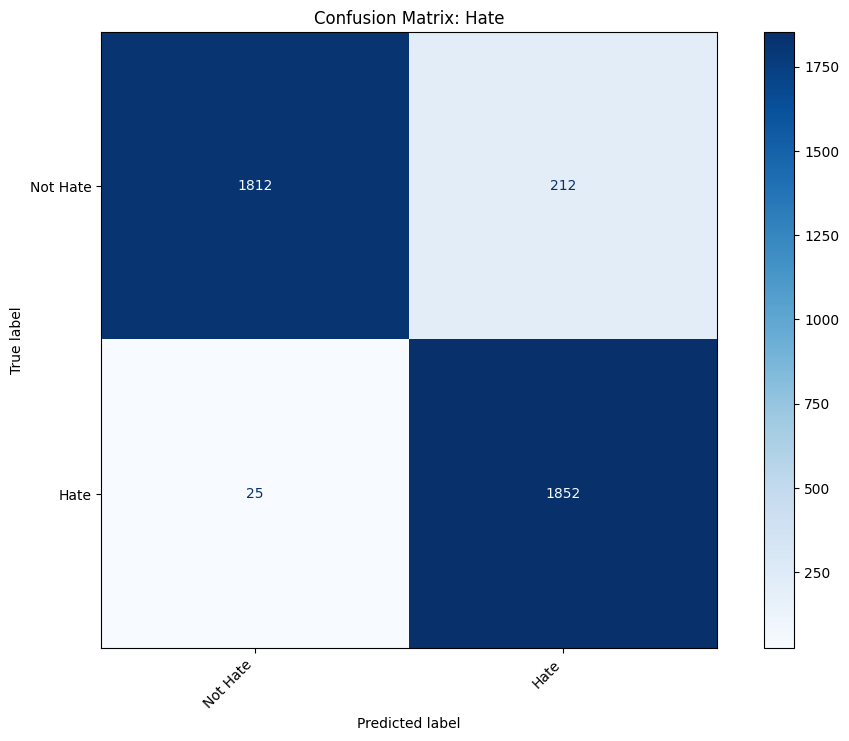

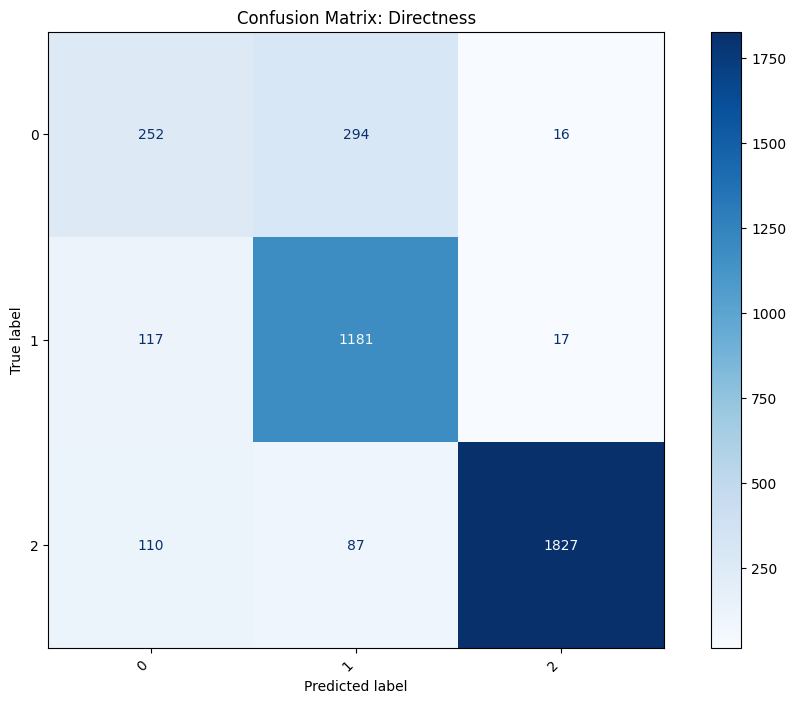

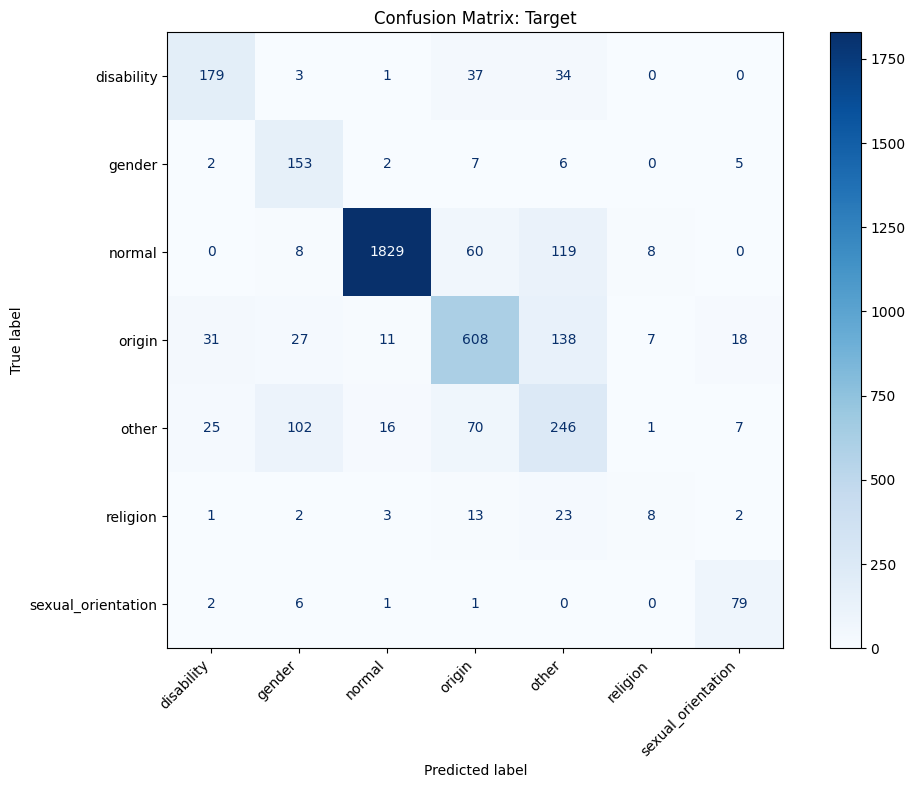

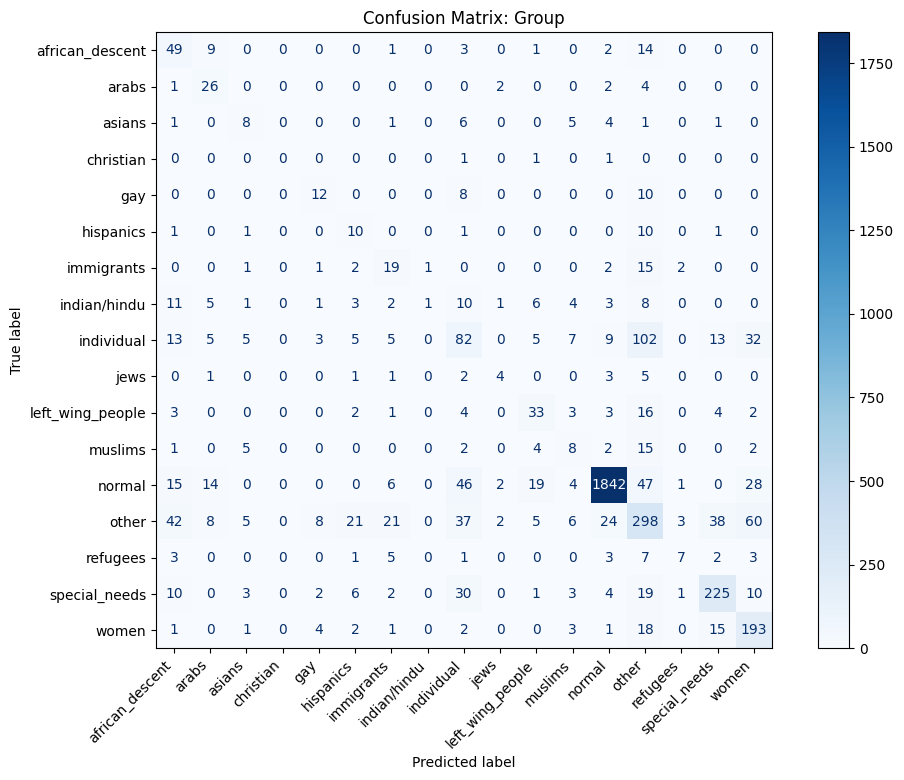

In [ ]:
task_names = {
    'hate': ['Not Hate', 'Hate'],
    'directness': ['0', '1', '2'],
    'target': [ "disability", "gender",  "normal", "origin","other","religion", "sexual_orientation"],
    'group': ["african_descent", "arabs", "asians", "christian","gay","hispanics", "immigrants","indian/hindu", "individual","jews", "left_wing_people","muslims", "normal","other", "refugees", "special_needs","women"]
}

for task, labels in task_names.items():
    cm = confusion_matrix(all_labels[task], all_preds[task])
    plt.figure(figsize=(12, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), xticks_rotation=45)
    plt.title(f"Confusion Matrix: {task.capitalize()}")
    plt.xticks(rotation=45, ha="right")
    plt.show()


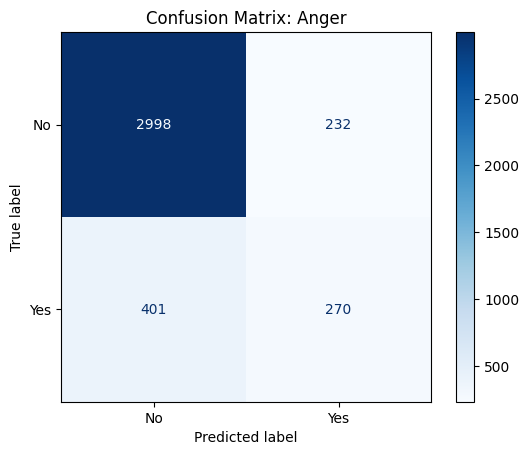

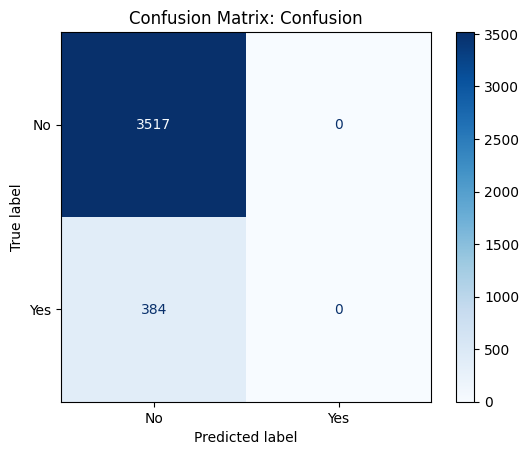

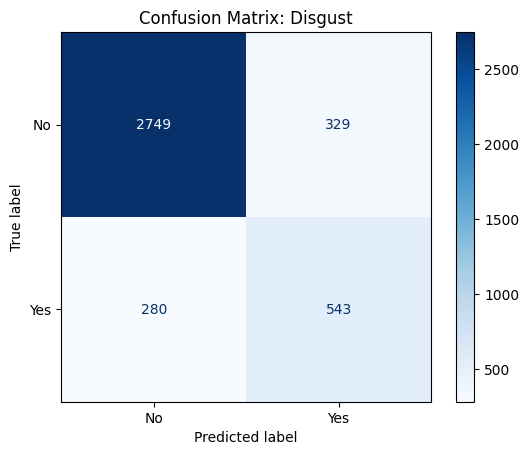

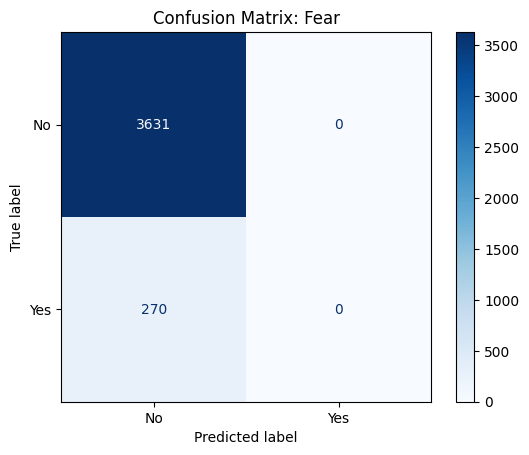

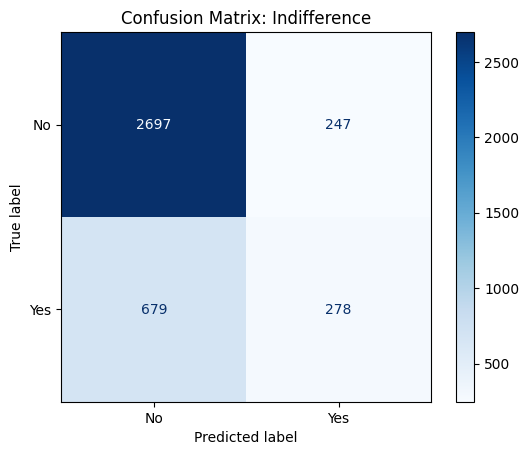

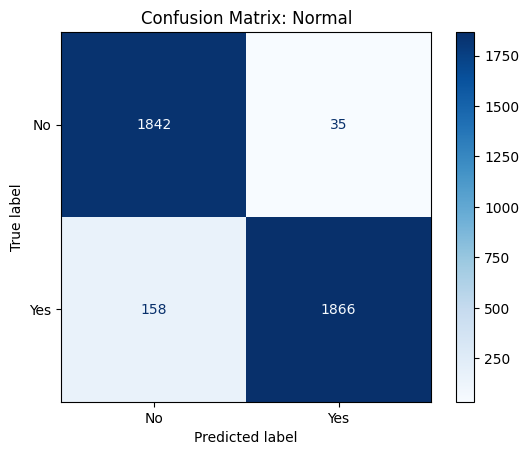

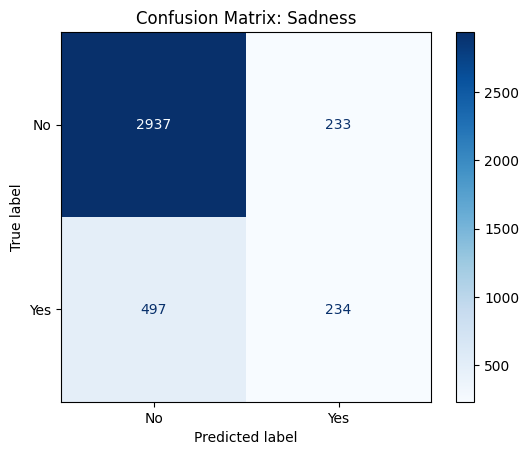

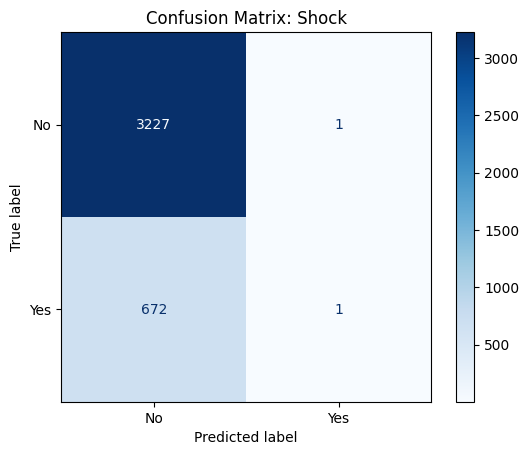

In [30]:
sentiment_names = ['anger', 'confusion', 'disgust', 'fear', 'indifference', 'normal', 'sadness', 'shock']
import numpy as np

all_preds_sent = np.array(all_preds['sentiments'])
all_labels_sent = np.array(all_labels['sentiments'])

for i, sentiment in enumerate(sentiment_names):
    cm = confusion_matrix(all_labels_sent[:, i], all_preds_sent[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: {sentiment.capitalize()}")
    plt.show()


language confusion matrix

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import defaultdict

def plot_confusion_matrix_by_language(model, dataloader, task='group', id2label=None, id2lang=None, device='cuda'):
    model.eval()
    all_preds_by_lang = defaultdict(list)
    all_labels_by_lang = defaultdict(list)

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            language = batch['language'].cpu().numpy()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            if task == 'group':
                preds = torch.argmax(outputs['group'], dim=1).cpu().numpy()
                labels = batch['group'].cpu().numpy()
            elif task == 'hate':
                preds = (outputs['hate'] > 0.5).long().cpu().numpy()
                labels = batch['hate'].cpu().numpy()
            elif task == 'target':
                preds = torch.argmax(outputs['target'], dim=1).cpu().numpy()
                labels = batch['target'].cpu().numpy()
            elif task == 'directness':
                preds = torch.argmax(outputs['directness'], dim=1).cpu().numpy()
                labels = batch['directness'].cpu().numpy()
            elif task == 'sentiments':
                preds = torch.argmax(outputs['sentiments'], dim=1).cpu().numpy()
                labels = torch.argmax(batch['sentiments'], dim=1).cpu().numpy()

            else:
                raise ValueError(f"Unknown task: {task}")

            for lang_id, p, l in zip(language, preds, labels):
                all_preds_by_lang[lang_id].append(p)
                all_labels_by_lang[lang_id].append(l)

    for lang_id in all_preds_by_lang:
        preds = all_preds_by_lang[lang_id]
        labels = all_labels_by_lang[lang_id]
        cm = confusion_matrix(labels, preds)

        lang_name = id2lang[lang_id] if id2lang else f'Lang {lang_id}'
        class_names = [id2label[i] for i in range(cm.shape[0])] if id2label else [str(i) for i in range(cm.shape[0])]

        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
        plt.title(f'Confusion Matrix for {task.upper()} - {lang_name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()


In [33]:
# Map language IDs back to string names
#id2lang = {v: k for k, v in language2id.items()}

# If you have label names (optional)
#id2label_group = {0: 'Race', 1: 'Religion', ..., 16: 'Other'}  # customize this
id2label_group  = {
    'hate': ['Not Hate', 'Hate'],
    'directness': ['0', '1', '2'],
    'target': ["disability", "gender", "normal", "origin", "other", "religion", "sexual_orientation"],
    'group': ["african_descent", "arabs", "asians", "christian", "gay", "hispanics", "immigrants",
              "indian/hindu", "individual", "jews", "left_wing_people", "muslims", "normal", "other",
              "refugees", "special_needs", "women"],
    'sentiments': [col.replace('sentiment_', '') for col in sentiment_cols]
}
# Extract all unique languages and map them to IDs
languages = val_df['language'].unique()
language2id = {lang: idx for idx, lang in enumerate(sorted(languages))}
id2lang = {v: k for k, v in language2id.items()}

# # Then run:
# plot_confusion_matrix_by_language(
#     model,
#     val_loader,
#     task='group',  # or 'target' or 'directness'
#     id2label=id2label_group,
#     id2lang=id2lang,
#     device='cuda'  # or 'cpu'
# )


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.1

KeyError: 0

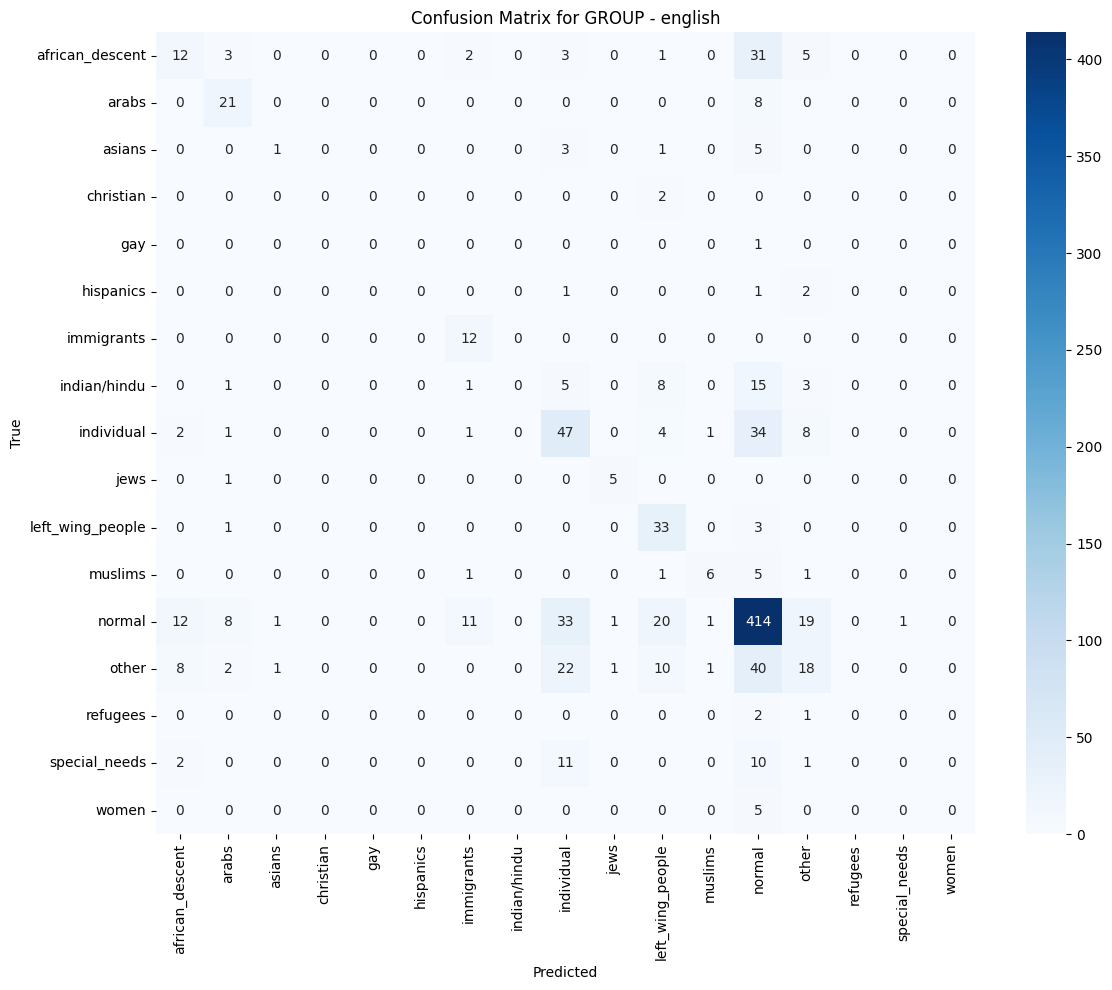

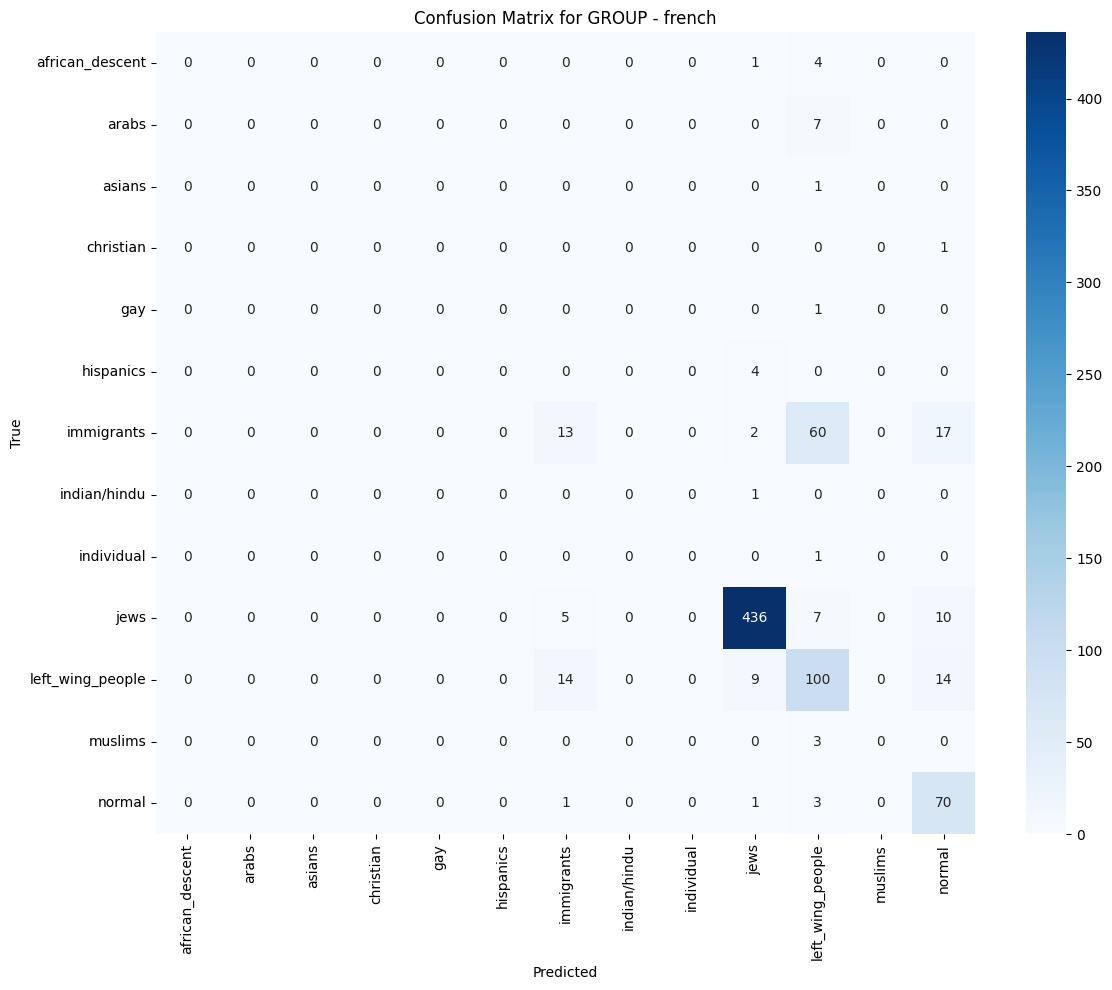

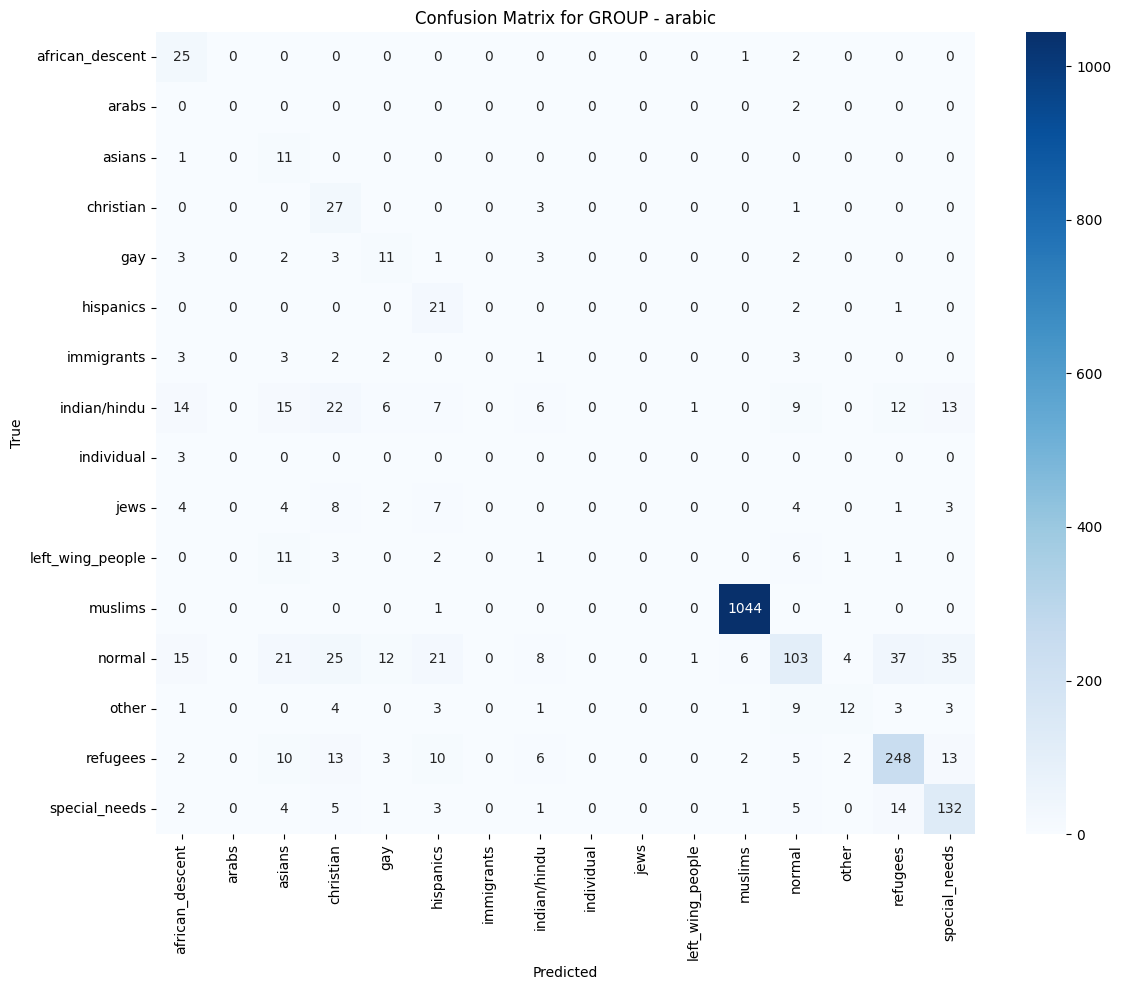

In [38]:
id2label={i: label for i, label in enumerate(id2label_group['group'])}

plot_confusion_matrix_by_language(
    model,
    val_loader,
    task='group',
    id2label={i: label for i, label in enumerate(id2label_group['group'])},
    id2lang=id2lang,
    device='cuda'
)

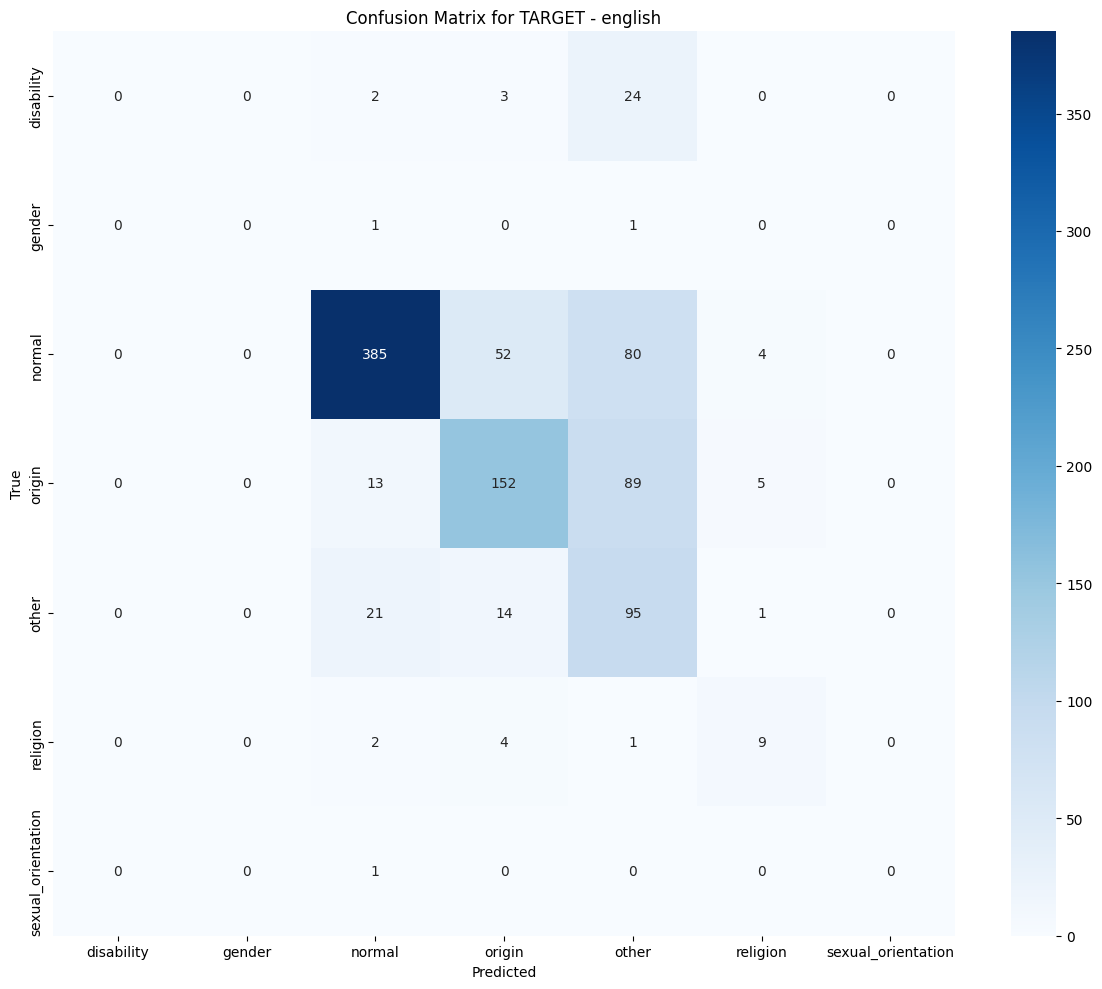

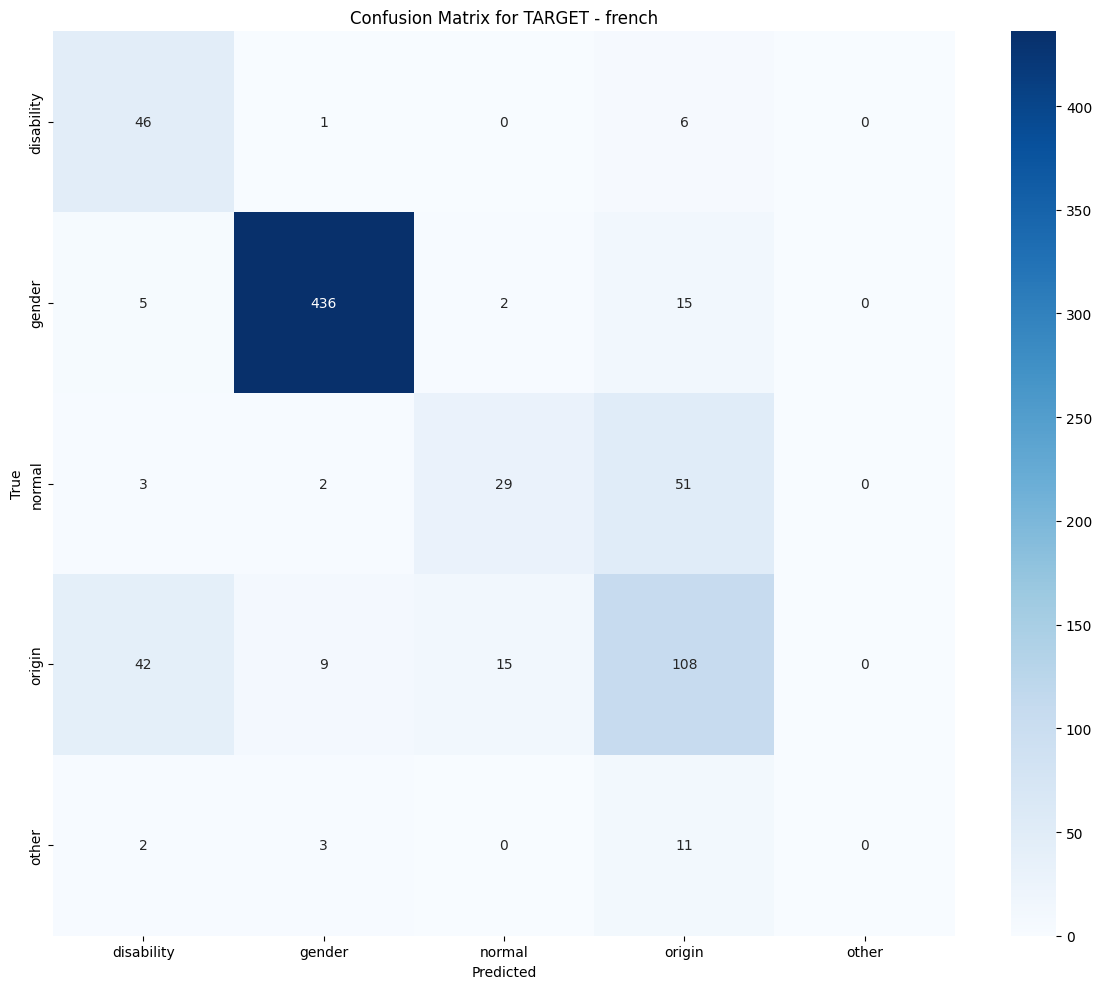

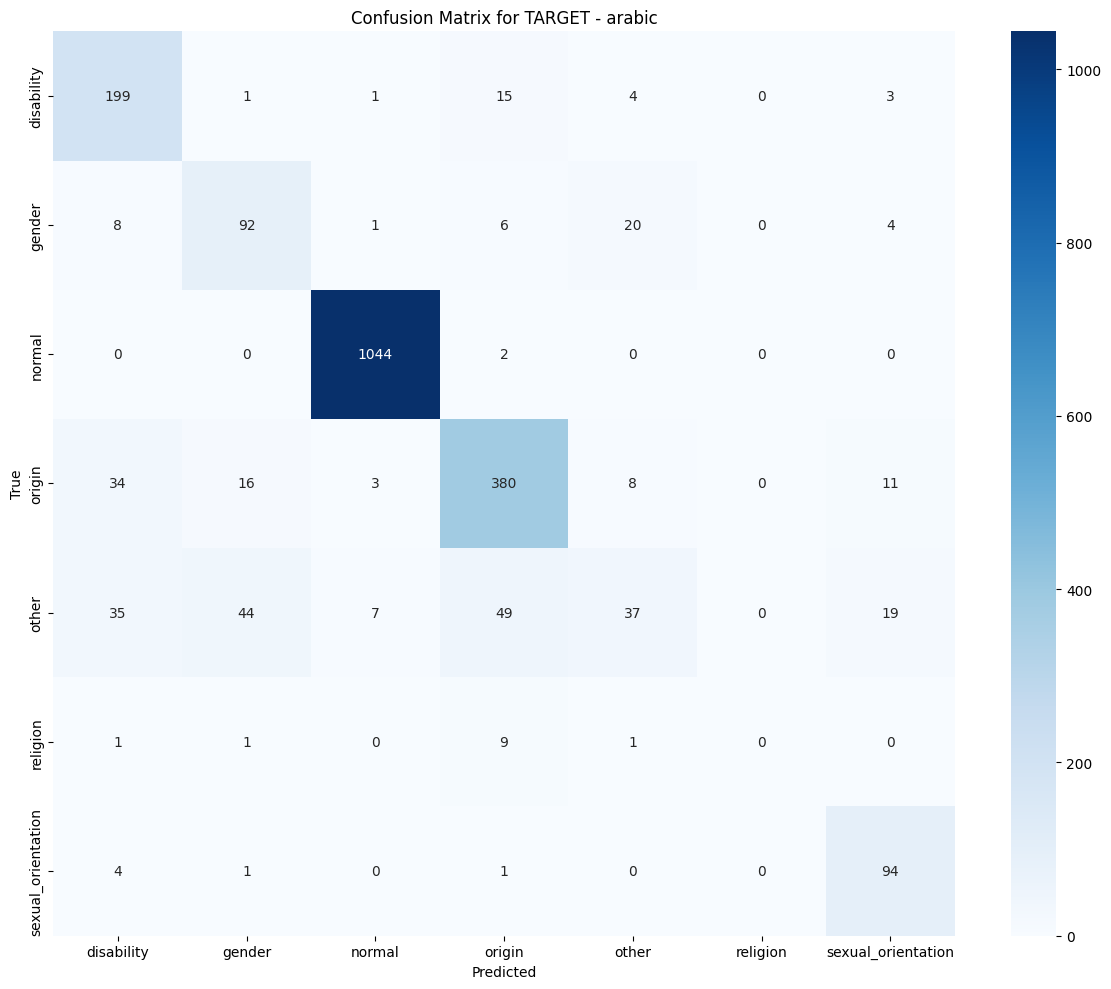

In [42]:
id2label={i: label for i, label in enumerate(id2label_group['target'])}

plot_confusion_matrix_by_language(
    model,
    val_loader,
    task='target',
    id2label={i: label for i, label in enumerate(id2label_group['target'])},
    id2lang=id2lang,
    device='cuda'
)

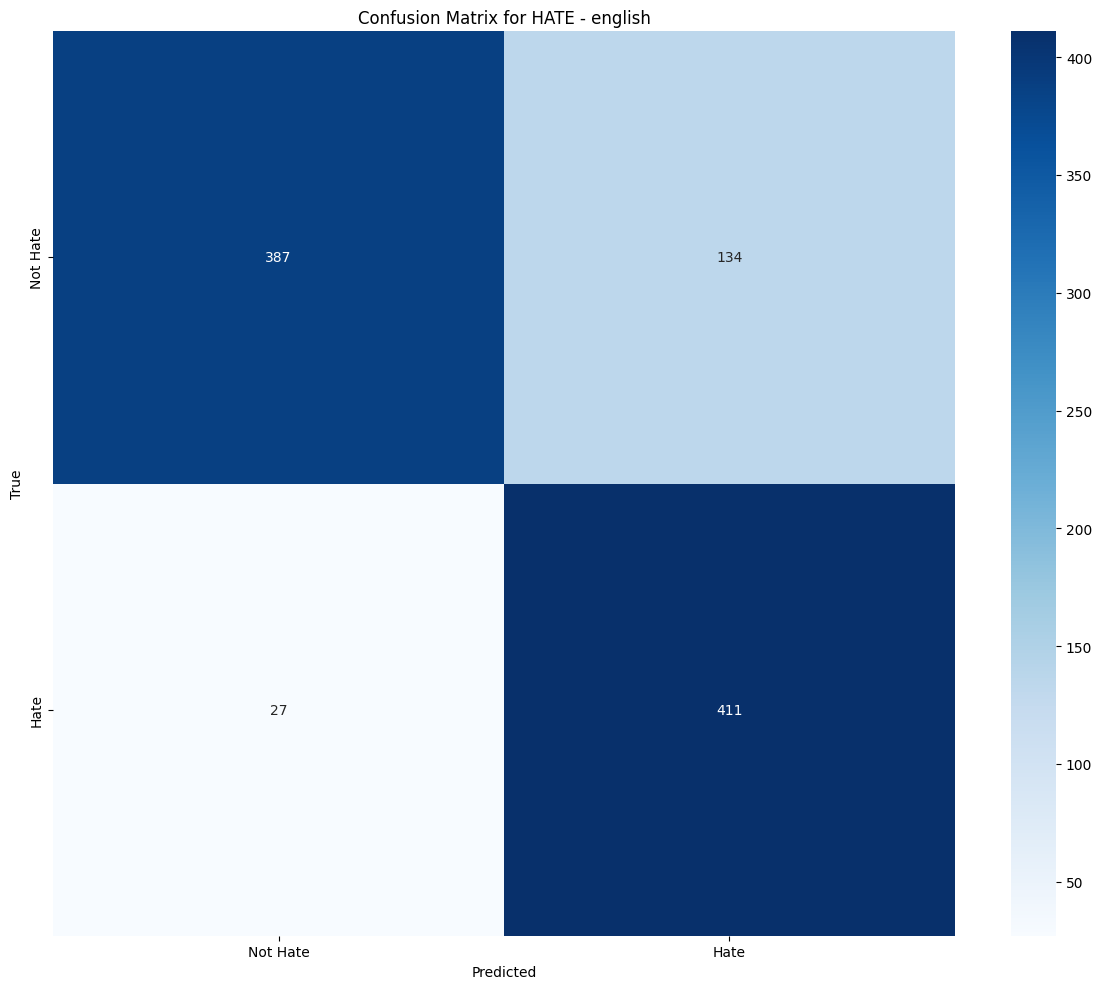

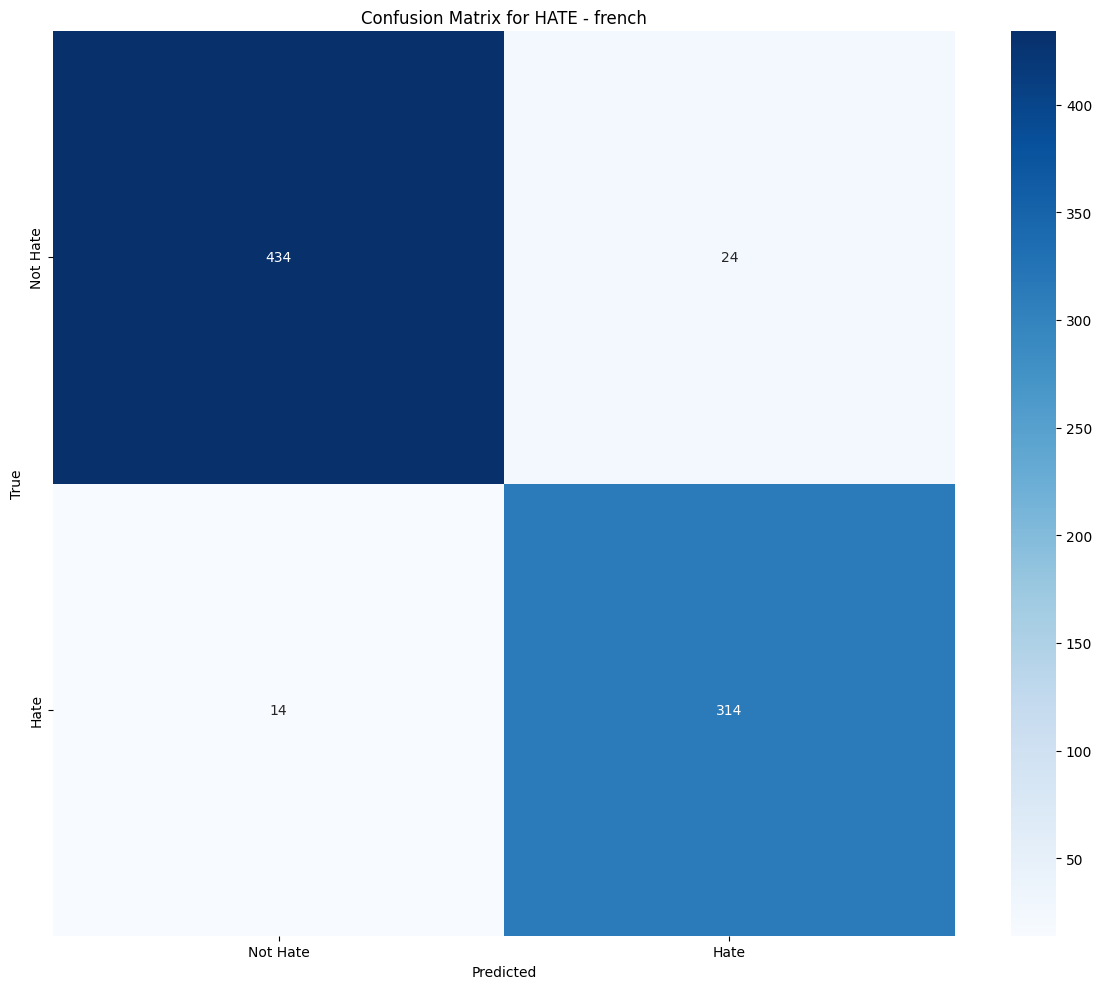

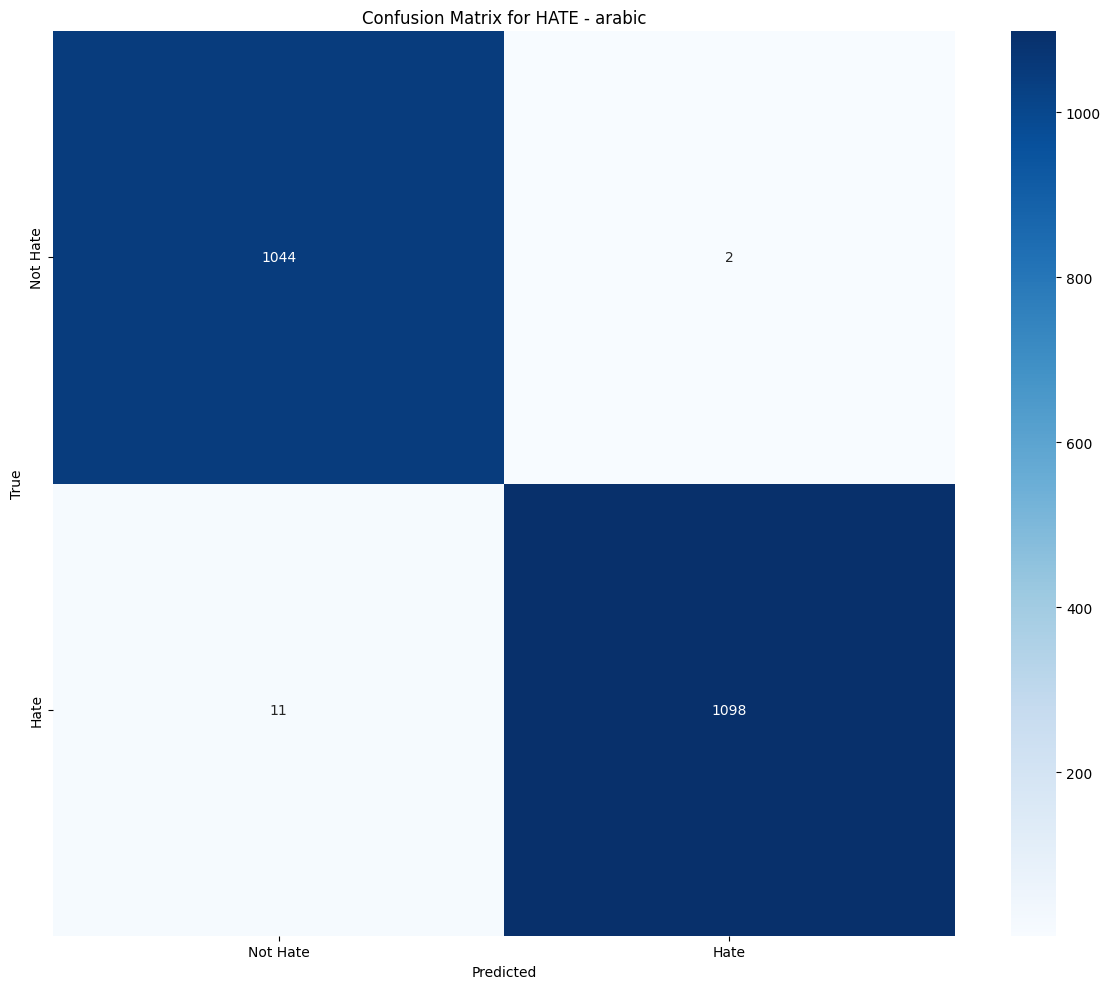

In [50]:
id2label={i: label for i, label in enumerate(id2label_group['hate'])}

plot_confusion_matrix_by_language(
    model,
    val_loader,
    task='hate',
    id2label={i: label for i, label in enumerate(id2label_group['hate'])},
    id2lang=id2lang,
    device='cuda'
)

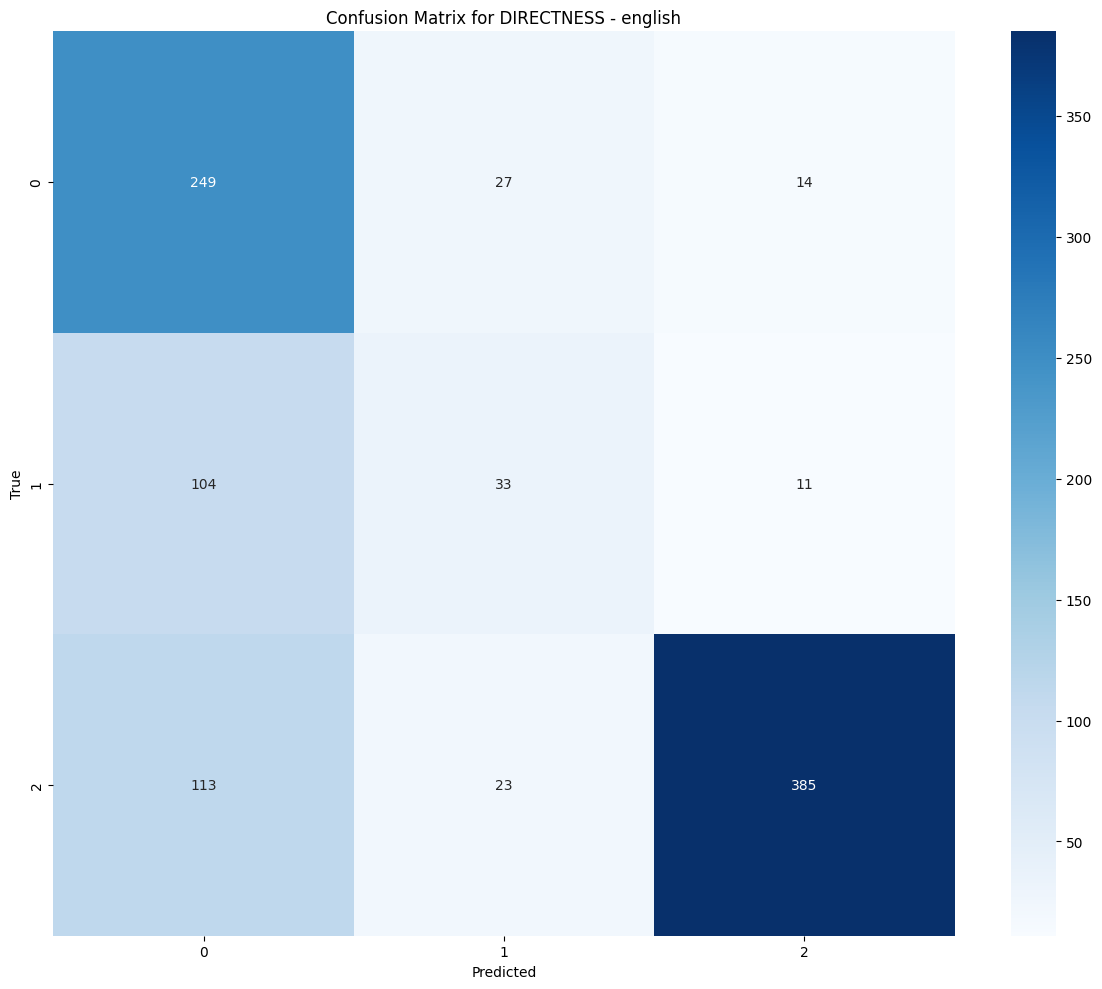

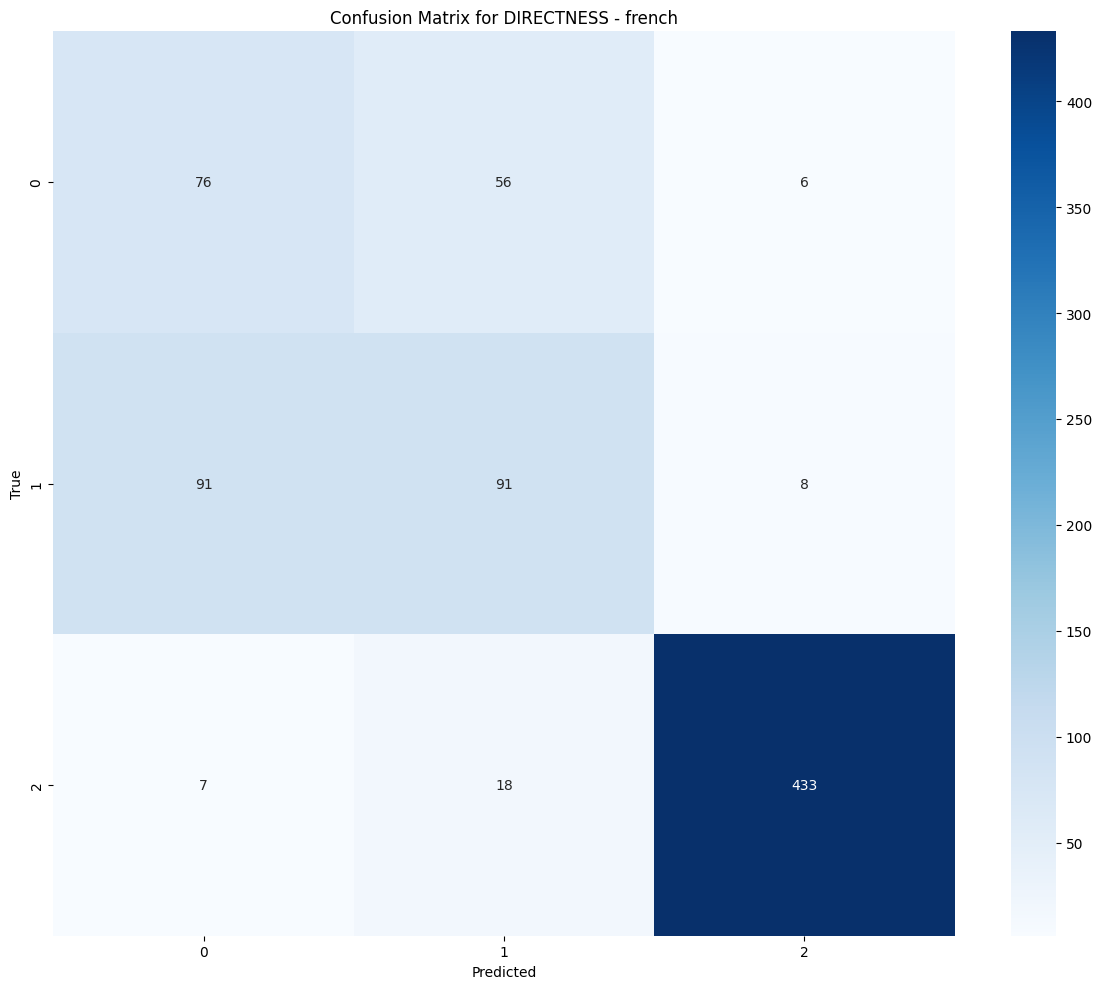

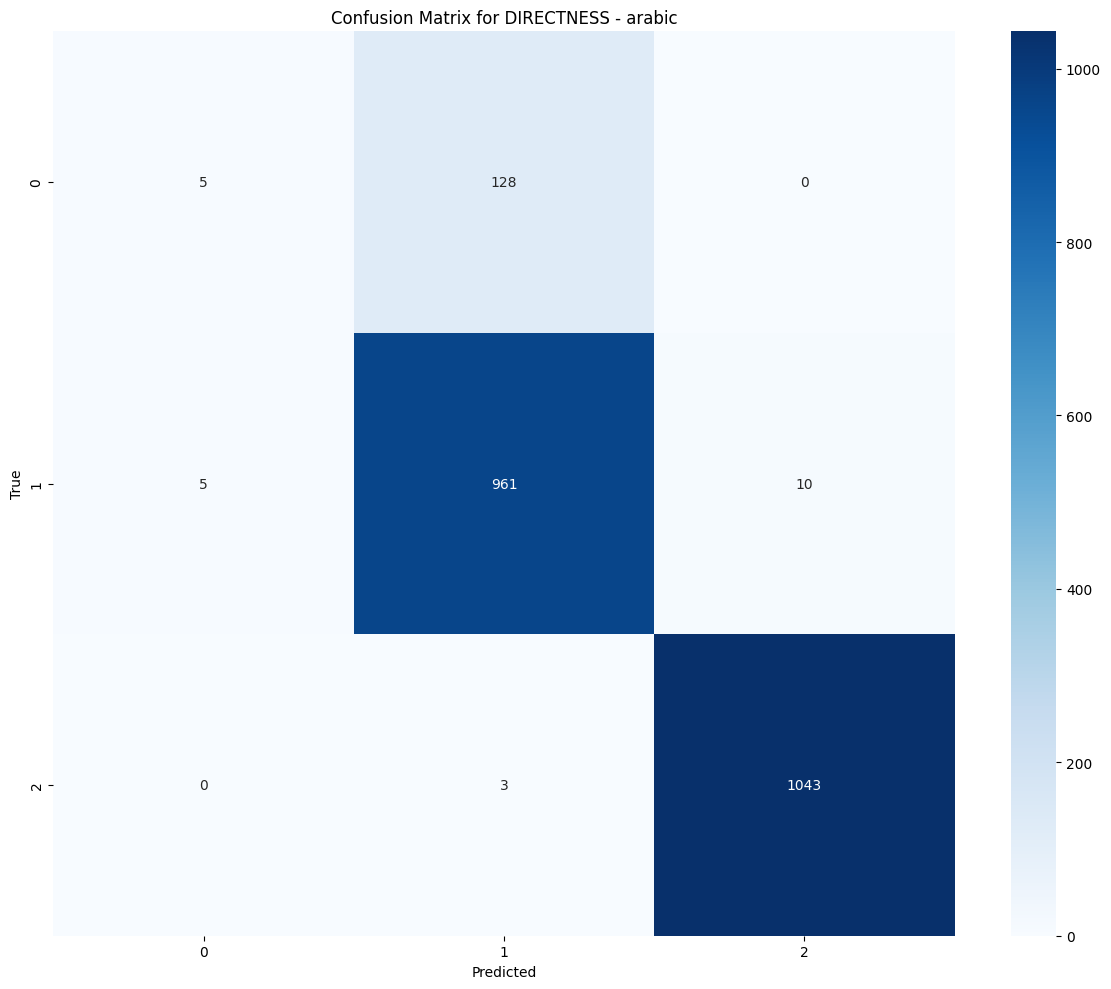

In [43]:
id2label={i: label for i, label in enumerate(id2label_group['directness'])}

plot_confusion_matrix_by_language(
    model,
    val_loader,
    task='directness',
    id2label={i: label for i, label in enumerate(id2label_group['directness'])},
    id2lang=id2lang,
    device='cuda'
)

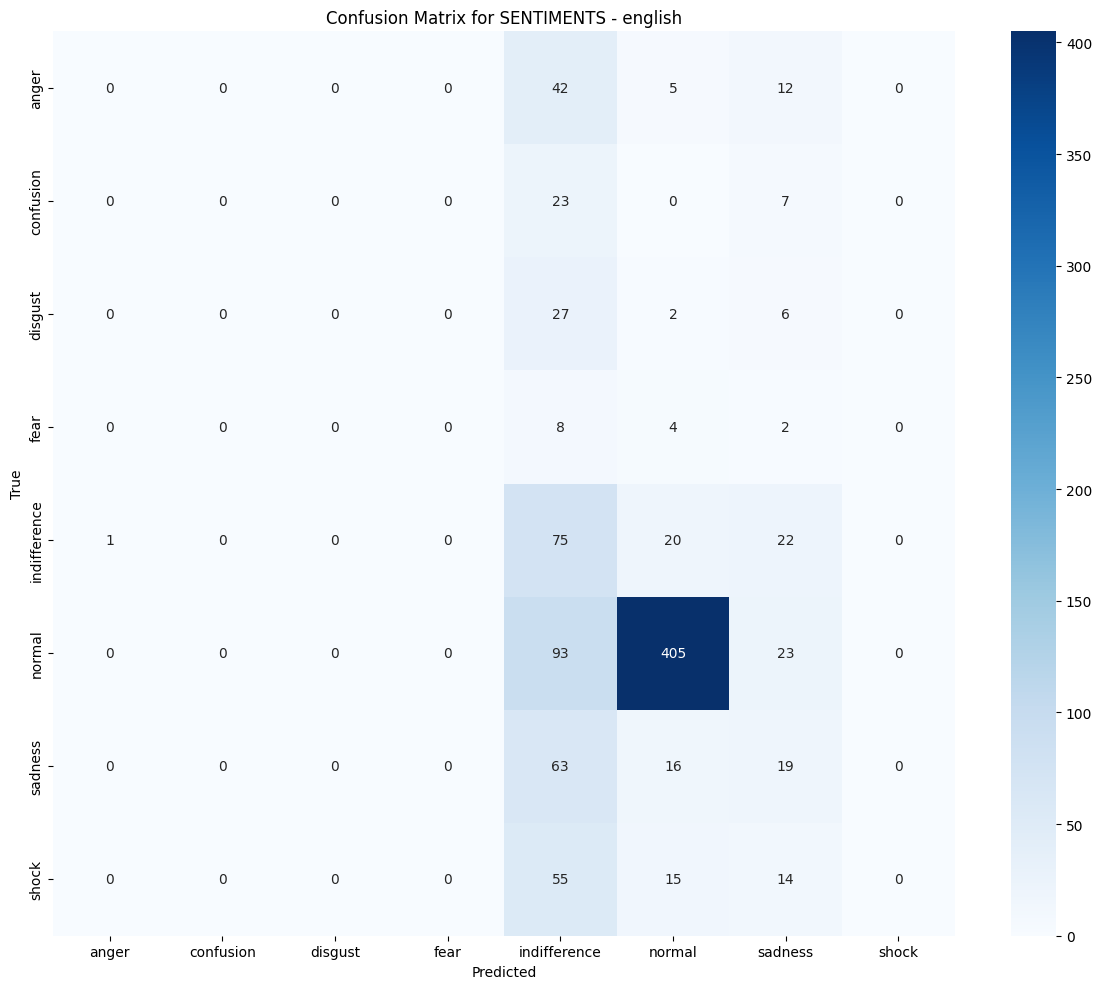

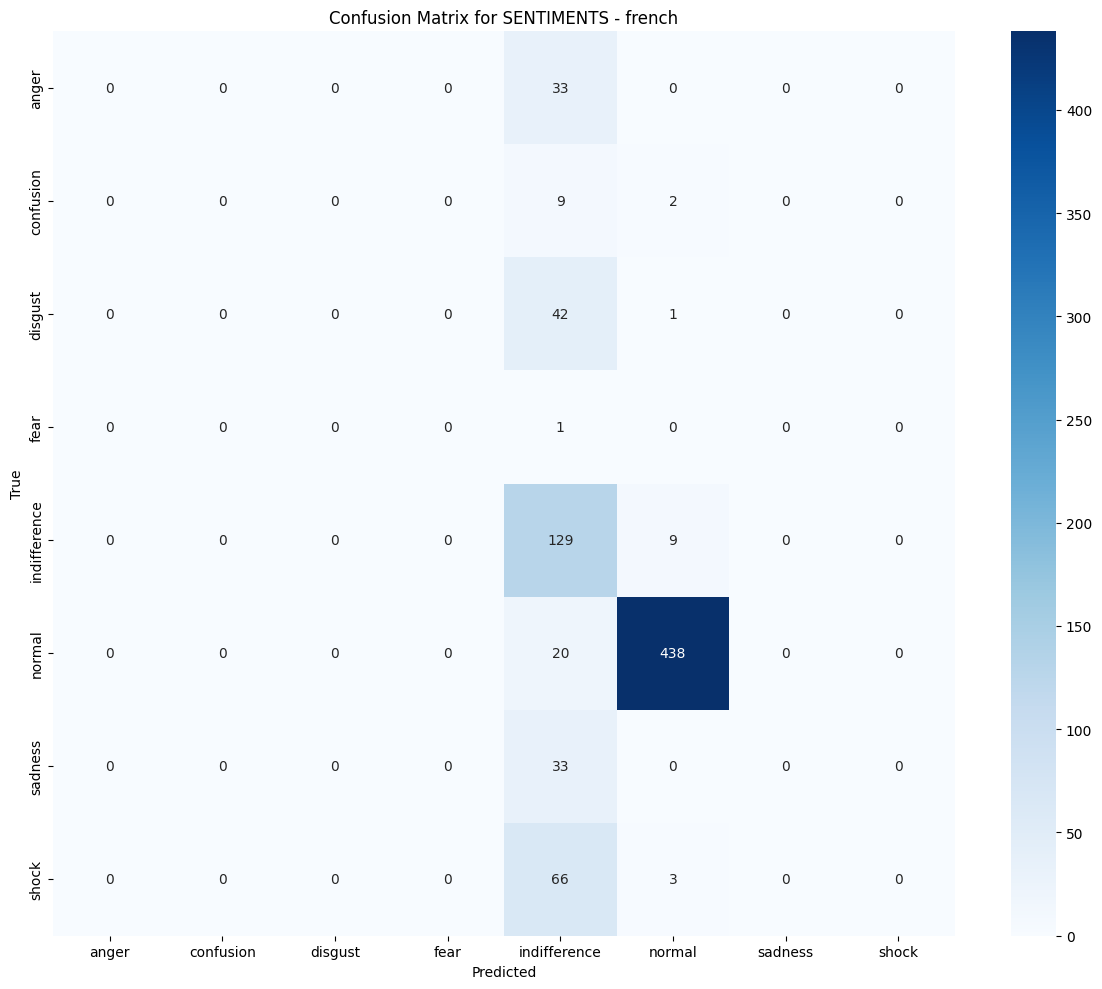

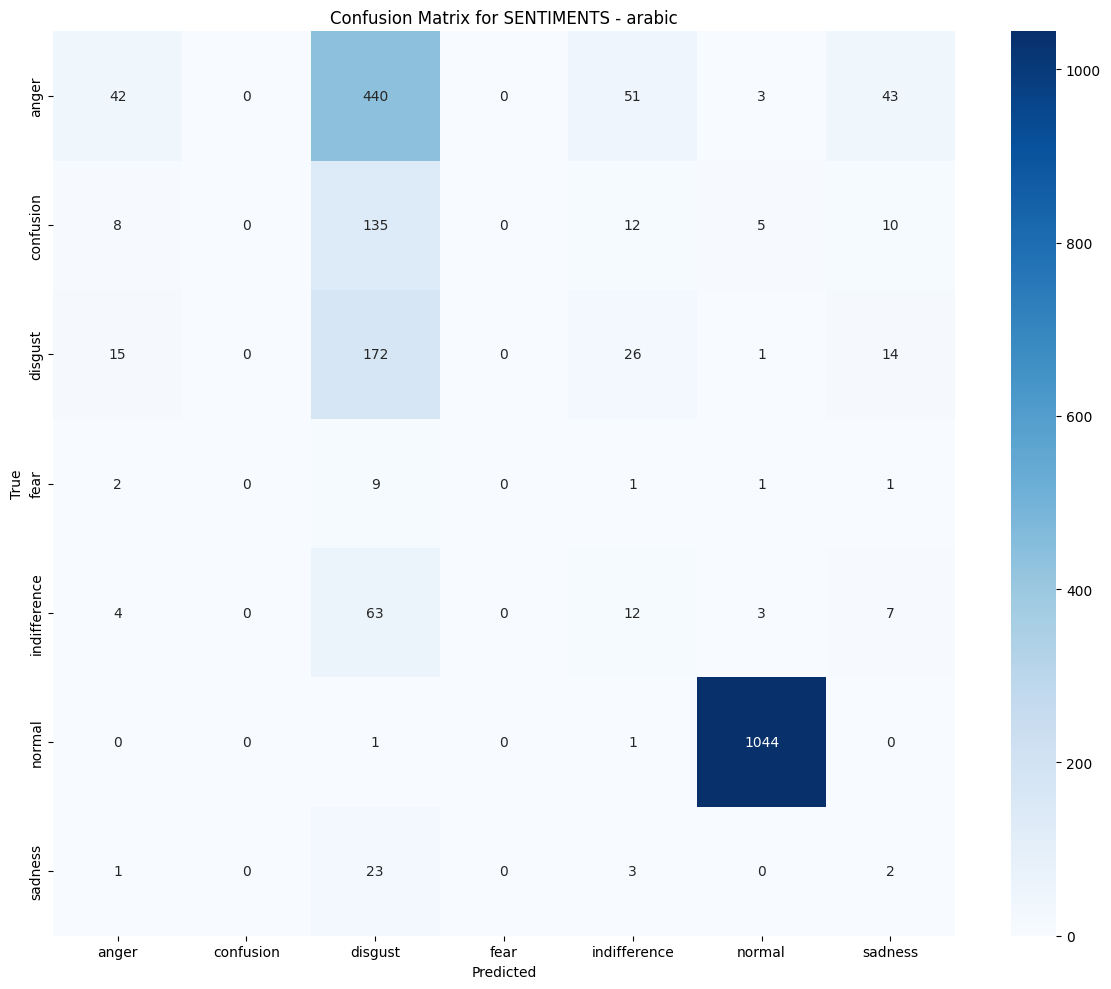

In [46]:
id2label={i: label for i, label in enumerate(id2label_group['sentiments'])}

plot_confusion_matrix_by_language(
    model,
    val_loader,
    task='sentiments',
    id2label={i: label for i, label in enumerate(id2label_group['sentiments'])},
    id2lang=id2lang,
    device='cuda'
)